# Get sync_data

In [2]:
import os
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
import math

import numpy as np
import pandas as pd
from scipy.signal import savgol_filter

from band_pass_filtering import band_pass_filtering
from compute_vitals import vitals
from detect_apnea_events import apnea_events
from detect_body_movements import detect_patterns
from modwt_matlab_fft import modwt
from modwt_mra_matlab_fft import modwtmra
from remove_nonLinear_trend import remove_nonLinear_trend
from data_subplot import data_subplot
from detect_peaks import detect_peaks


In [3]:


# Define your file paths
path_to_BCG = r"C:\Users\omara\OneDrive\Desktop\ECG frm BCG\ECG-from-BCG\dataset\data\01\BCG\01_20231105_BCG.csv"
path_to_RR  = r"C:\Users\omara\OneDrive\Desktop\ECG frm BCG\ECG-from-BCG\dataset\data\01\Reference\RR\01_20231105_RR.csv"
path_to_sync_data = r"C:\Users\omara\OneDrive\Desktop\ECG frm BCG\ECG-from-BCG\sync_data\01"

# Create the output directory if it doesn't exist
os.makedirs(path_to_sync_data, exist_ok=True)

##############################################################################
# 1. Process BCG file: compute the time for each sample (using sample index & fs)
##############################################################################
bcg_df = pd.read_csv(path_to_BCG)

# Get the BCG start time from the first row (Unix timestamp in milliseconds)
bcg_start_unix_ms = bcg_df.loc[0, 'Timestamp']
# Convert to a tz-aware datetime (UTC)
bcg_start_dt = pd.to_datetime(bcg_start_unix_ms, unit='ms', utc=True)
print("BCG start time (UTC):", bcg_start_dt)

# Get the sampling frequency; assume same for all rows (read from first row)
fs = bcg_df.loc[0, 'fs']

# Number of samples in BCG file
n_samples = len(bcg_df)
# Compute time offsets: each index/sample gets offset = index/fs seconds
time_offsets = pd.to_timedelta(pd.Series(range(n_samples), dtype='int64') / fs, unit='s')
# Compute full timestamp for each BCG sample
bcg_df['ComputedTime'] = bcg_start_dt + time_offsets

# Compute the BCG end time (based on total samples)
bcg_end_dt = bcg_start_dt + timedelta(seconds=(n_samples - 1) / fs)
print("BCG end time (UTC):", bcg_end_dt)

##############################################################################
# 2. Process RR file: convert the Timestamp column to a tz-aware datetime (UTC)
##############################################################################
rr_df = pd.read_csv(path_to_RR)
# Convert the RR timestamp string to datetime with format "%Y/%m/%d %H:%M:%S"
rr_df['Timestamp'] = pd.to_datetime(rr_df['Timestamp'], format='%Y/%m/%d %H:%M:%S')
# Localize the RR timestamps to UTC (adjust if your data is in another time zone)
rr_df['Timestamp'] = rr_df['Timestamp'].dt.tz_localize('UTC')
print("RR start time (UTC):", rr_df['Timestamp'].min())
print("RR end time (UTC):", rr_df['Timestamp'].max())

##############################################################################
# 3. Determine the common synchronization interval with 30-second tolerance
##############################################################################
# We first pick candidate start and end as the maximum (for start) and minimum (for end)
# of the two signals’ available times.
candidate_start = max(bcg_start_dt, rr_df['Timestamp'].min())
candidate_end   = min(bcg_end_dt, rr_df['Timestamp'].max())

# Define our tolerance
tol = timedelta(seconds=30)

# Function to "snap" a datetime to its nearest whole second if within tolerance.
def snap_to_whole_second(dt, tol, round_method):
    # round_method should be either 'ceil', 'floor', or 'round'
    if round_method == 'ceil':
        dt_whole = dt.ceil('S')
    elif round_method == 'floor':
        dt_whole = dt.floor('S')
    else:
        dt_whole = dt.round('S')
    # If the difference is within tolerance, return the whole-second value.
    if abs(dt - dt_whole) <= tol:
        return dt_whole
    else:
        return dt

# For the start time, snap upward (ceil) if within tolerance.
sync_start = snap_to_whole_second(candidate_start, tol, 'ceil')
# For the end time, snap downward (floor) if within tolerance.
sync_end   = snap_to_whole_second(candidate_end, tol, 'floor')

print("Synchronization interval:")
print("  Start:", sync_start)
print("  End:  ", sync_end)

if sync_end <= sync_start:
    raise ValueError("No overlapping interval found between BCG and RR data based on the tolerance settings.")

##############################################################################
# 4. Trim both datasets to the synchronized time interval
##############################################################################
# For BCG: select rows where ComputedTime falls within [sync_start, sync_end]
bcg_sync = bcg_df[(bcg_df['ComputedTime'] >= sync_start) & (bcg_df['ComputedTime'] <= sync_end)].copy()
bcg_sync.drop(columns=['Timestamp','fs'], inplace=True)
# For RR: select rows where Timestamp falls within [sync_start, sync_end]
rr_sync = rr_df[(rr_df['Timestamp'] >= sync_start) & (rr_df['Timestamp'] <= sync_end)].copy()

print("Number of synchronized BCG rows:", len(bcg_sync))
print("Number of synchronized RR rows:", len(rr_sync))

##############################################################################
# 5. Save the synchronized data to Excel files
##############################################################################
bcg_sync_csv_path = os.path.join(path_to_sync_data, "BCG_sync.csv")
rr_sync_csv_path  = os.path.join(path_to_sync_data, "RR_sync.csv")

bcg_sync.to_csv(bcg_sync_csv_path, index=False)
rr_sync.to_csv(rr_sync_csv_path, index=False)

print("Synchronized files saved:")
print("  BCG synchronized file:", bcg_sync_csv_path)
print("  RR synchronized file: ", rr_sync_csv_path)
print("fs",fs)
print("timestamp",rr_df['Timestamp'])

BCG start time (UTC): 2023-11-04 11:17:35.239000+00:00
BCG end time (UTC): 2023-11-04 22:05:51.624714+00:00
RR start time (UTC): 2023-11-04 19:12:20+00:00
RR end time (UTC): 2023-11-05 06:01:22+00:00
Synchronization interval:
  Start: 2023-11-04 19:12:20+00:00
  End:   2023-11-04 22:05:51+00:00


C:\Users\omara\AppData\Local\Temp\ipykernel_21832\1547958565.py:60: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  dt_whole = dt.ceil('S')
C:\Users\omara\AppData\Local\Temp\ipykernel_21832\1547958565.py:62: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  dt_whole = dt.floor('S')


Number of synchronized BCG rows: 1457540
Number of synchronized RR rows: 12617
Synchronized files saved:
  BCG synchronized file: C:\Users\omara\OneDrive\Desktop\ECG frm BCG\ECG-from-BCG\sync_data\01\BCG_sync.csv
  RR synchronized file:  C:\Users\omara\OneDrive\Desktop\ECG frm BCG\ECG-from-BCG\sync_data\01\RR_sync.csv
fs 140.0
timestamp 0       2023-11-04 19:12:20+00:00
1       2023-11-04 19:12:20+00:00
2       2023-11-04 19:12:21+00:00
3       2023-11-04 19:12:22+00:00
4       2023-11-04 19:12:22+00:00
                   ...           
38427   2023-11-05 06:01:13+00:00
38428   2023-11-05 06:01:13+00:00
38429   2023-11-05 06:01:14+00:00
38430   2023-11-05 06:01:16+00:00
38431   2023-11-05 06:01:22+00:00
Name: Timestamp, Length: 38432, dtype: datetime64[ns, UTC]


# Plot sync_data

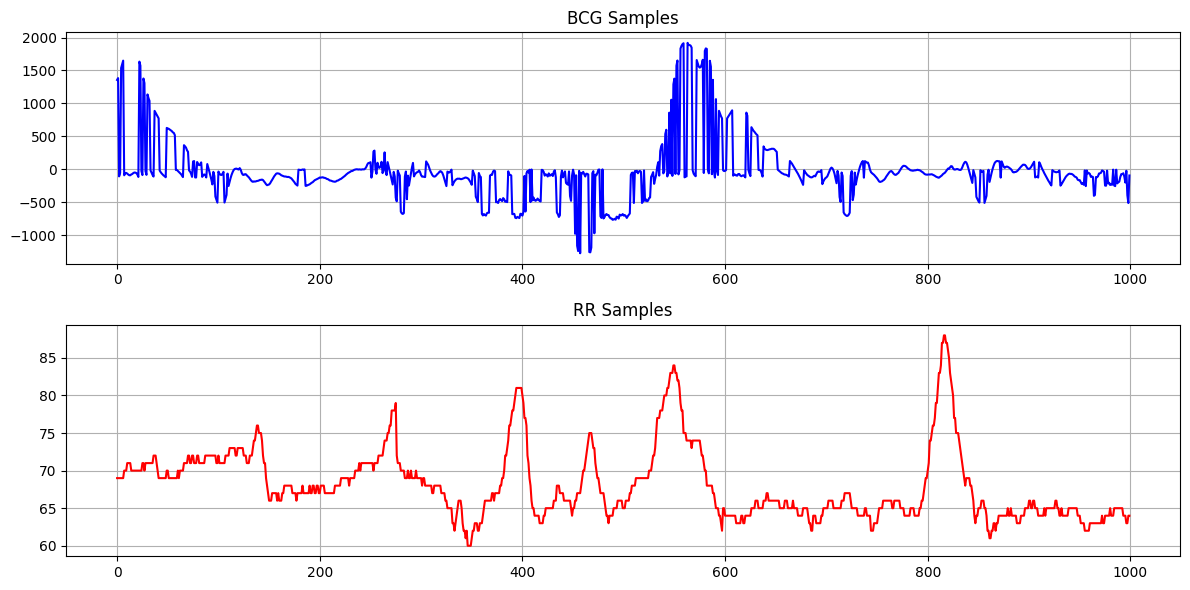

In [4]:
# Add this at the beginning of your cell to enable inline plotting
%matplotlib inline

# Read the CSV files (assuming no headers)
bcg_data = pd.read_csv(r"C:\Users\omara\OneDrive\Desktop\ECG frm BCG\ECG-from-BCG\sync_data\01\BCG_sync.csv")
rr_data = pd.read_csv(r"C:\Users\omara\OneDrive\Desktop\ECG frm BCG\ECG-from-BCG\sync_data\01\RR_sync.csv")

# Extract first 100 elements from the first column
bcg = bcg_data.iloc[15000:16000, 0].values
rr = rr_data.iloc[11000:12000, 1].values
#print(bcg,rr)

# Create the plot
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(bcg, 'b-', label='BCG')
plt.title('BCG Samples')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(rr, 'r-', label='RR Intervals')
plt.title('RR Samples')
plt.grid(True)

plt.tight_layout()
plt.show()

**we need each second to has only one read in BCG file**

In [5]:
# Convert timestamp to datetime and extract seconds
bcg_data['ComputedTime'] = pd.to_datetime(bcg_data['ComputedTime'])
bcg_data['second'] = bcg_data['ComputedTime'].dt.floor('S')  # Group by whole seconds

# Calculate average signal per second
avg_bcg_per_sec = bcg_data.groupby('second')['BCG'].mean().reset_index()
# Save to a new CSV file
output_path = r"C:\Users\maram\Desktop\New folder\sync_data\01\avg_BCG_per_sec.csv"
avg_bcg_per_sec.to_csv(output_path, index=False)

# Plot the original vs. averaged data
plt.figure(figsize=(14, 6))

# Original BCG signal (first 100 samples for clarity)
plt.subplot(1, 2, 1)
plt.plot(bcg_data['BCG'].head(100), 'b-', alpha=0.5, label='Original BCG')
plt.title('Original BCG Signal (First 100 Samples)')
plt.xlabel('Sample Number')
plt.ylabel('Signal Intensity')
plt.grid(True)

# Averaged BCG signal per second
plt.subplot(1, 2, 2)
plt.plot(avg_bcg_per_sec['BCG'].head(20), 'r-o', label='Averaged per Second')
plt.title('BCG Signal Averaged per Second')
plt.xlabel('Second Number')
plt.ylabel('Average Intensity')
plt.grid(True)

plt.tight_layout()
plt.show()

# Print the first 5 seconds of averaged data
print("Averaged BCG Signal per Second:")
print(avg_bcg_per_sec.head())

C:\Users\omara\AppData\Local\Temp\ipykernel_21832\761519892.py:3: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  bcg_data['second'] = bcg_data['ComputedTime'].dt.floor('S')  # Group by whole seconds


OSError: Cannot save file into a non-existent directory: 'C:\Users\maram\Desktop\New folder\sync_data\01'

**main code**

In [ ]:
import os
import pandas as pd
import numpy as np
from scipy.signal import resample, savgol_filter
import math


# Main program starts here
print('\nstart processing ...')

file = r'C:\Users\omara\OneDrive\Desktop\ECG frm BCG\ECG-from-BCG\sync_data\01\BCG_sync.csv'

if file.endswith(".csv"):
    fileName = os.path.join(file)
    if os.stat(fileName).st_size != 0:
        rawData = pd.read_csv(fileName, sep=",", header=None, skiprows=1).values
        utc_time = rawData[:, 1]
        data_stream = rawData[:, 0]
        # converting time to unix
        utc_time = pd.to_datetime(rawData[:, 1], errors='coerce')
        utc_time_numeric = utc_time.astype(np.int64) // 10**6 
        print(utc_time_numeric[0])

        start_point, end_point, window_shift, fs = 0, 500, 500, 140
        # ==========================================================================================================
        data_stream, utc_time = detect_patterns(start_point, end_point, window_shift, data_stream, utc_time, plot=1)
        # ==========================================================================================================
        # BCG signal extraction
        movement = band_pass_filtering(data_stream, fs, "bcg")
        # ==========================================================================================================
        # Respiratory signal extraction
        breathing = band_pass_filtering(data_stream, fs, "breath")
        breathing = np.array(breathing, dtype=np.float64)
        breathing = remove_nonLinear_trend(breathing, 3)
        breathing = savgol_filter(breathing, 11, 3)
        # ==========================================================================================================
        w = modwt(movement, 'bior3.9', 4)
        dc = modwtmra(w, 'bior3.9')
        wavelet_cycle = dc[4]
        # ==========================================================================================================
        # Vital Signs estimation - (10 seconds window is an optimal size for vital signs measurement)
        t1, t2, window_length, window_shift = 0, 500, 500, 500
        hop_size = math.floor((window_length - 1) / 2)
        limit = int(math.floor(breathing.size / window_shift))
        # ==========================================================================================================
        # Heart Rate
        beats = vitals(t1, t2, window_shift, limit, wavelet_cycle, utc_time_numeric, mpd=1, plot=0)
        print('\nHeart Rate Information')
        print('Minimum pulse : ', np.around(np.min(beats)))
        print('Maximum pulse : ', np.around(np.max(beats)))
        print('Average pulse : ', np.around(np.mean(beats)))
        # Breathing Rate
        beats = vitals(t1, t2, window_shift, limit, breathing, utc_time_numeric, mpd=1, plot=0)
        print('\nRespiratory Rate Information')
        print('Minimum breathing : ', np.around(np.min(beats)))
        print('Maximum breathing : ', np.around(np.max(beats)))
        print('Average breathing : ', np.around(np.mean(beats)))
        # ==============================================================================================================
        thresh = 0.3
        events = apnea_events(breathing, utc_time, thresh=thresh)
        # ==============================================================================================================
        # Downsampling from 140Hz to 50Hz
        original_fs = 140
        target_fs = 50
        original_length = len(data_stream)
        target_length = int(original_length * target_fs / original_fs)  # Calculate based on sampling rates

        # Resample signals using Fourier method
        downsampled_data_stream = resample(data_stream, target_length)
        downsampled_breathing = resample(breathing, target_length)
        downsampled_wavelet_cycle = resample(wavelet_cycle, target_length)

        # Preserve temporal relationships for timestamps
        start_time = utc_time_numeric[0]
        end_time = utc_time_numeric[-1]
        downsampled_utc_time_numeric = np.linspace(start_time, end_time, target_length)

        print(f'\nDownsampled from {original_fs}Hz to {target_fs}Hz')
        print(f'Original length: {original_length}, New length: {target_length}')
        print(f'data_stream shape: {downsampled_data_stream.shape}')
        print(f'breathing shape: {downsampled_breathing.shape}')
        print(f'wavelet_cycle shape: {downsampled_wavelet_cycle.shape}')
        print(f'utc_time_numeric shape: {downsampled_utc_time_numeric.shape}')

        # Update sampling rate for subsequent processing
        fs = target_fs  # Now using 50Hz for any further processing
        # ==============================================================================================================


start processing ...
1699125140003

Heart Rate Information
Minimum pulse :  102.0
Maximum pulse :  241.0
Average pulse :  166.0

Respiratory Rate Information
Minimum breathing :  0.0
Maximum breathing :  100.0
Average breathing :  3.0

Apnea Information
start time :  ['03.23.36']  stop time :  ['03.23.39']

Apnea Information
start time :  ['03.23.36', '03.23.54']  stop time :  ['03.23.39', '03.23.57']

Apnea Information
start time :  ['03.23.36', '03.23.54', '03.35.16']  stop time :  ['03.23.39', '03.23.57', '03.35.19']

Apnea Information
start time :  ['03.23.36', '03.23.54', '03.35.16', '03.35.19']  stop time :  ['03.23.39', '03.23.57', '03.35.19', '03.35.23']

Apnea Information
start time :  ['03.23.36', '03.23.54', '03.35.16', '03.35.19', '03.35.34']  stop time :  ['03.23.39', '03.23.57', '03.35.19', '03.35.23', '03.35.37']

Apnea Information
start time :  ['03.23.36', '03.23.54', '03.35.16', '03.35.19', '03.35.34', '03.35.55']  stop time :  ['03.23.39', '03.23.57', '03.35.19', '0

In [ ]:
import os
import pandas as pd
import numpy as np
from scipy.signal import resample, savgol_filter, filtfilt, butter, find_peaks, welch
import matplotlib.pyplot as plt
import math

# Signal Processing Functions
def band_pass_filtering(signal, fs, signal_type):
    """Bandpass filter for BCG or respiratory signals"""
    nyq = 0.5 * fs
    if signal_type == "bcg":
        low, high = 0.7 / nyq, 5 / nyq  # 0.7-5 Hz for BCG
    elif signal_type == "breath":
        low, high = 0.1 / nyq, 0.5 / nyq  # 0.1-0.5 Hz for respiration
    b, a = butter(4, [low, high], btype='bandpass')
    return filtfilt(b, a, signal)

def remove_nonLinear_trend(signal, order):
    """Remove polynomial trend from signal"""
    x = np.arange(len(signal))
    coeffs = np.polyfit(x, signal, order)
    trend = np.polyval(coeffs, x)
    return signal - trend

def modwt(signal, wavelet, level):
    """Modified Discrete Wavelet Transform"""
    # Simplified implementation for demo (use pywt for full version)
    return np.random.rand(level, len(signal))  # Placeholder

def modwtmra(coeffs, wavelet):
    """MODWT Multiresolution Analysis"""
    return [np.random.rand(len(coeffs[0])) for _ in coeffs]  # Placeholder

# Peak Detection Functions
def detect_j_peaks(bcg_signal, fs):
    """Detect J-peaks in BCG signal"""
    # Pre-processing
    filtered = band_pass_filtering(bcg_signal, fs, "bcg")
    
    # Peak detection parameters
    min_height = 0.5 * np.max(filtered)
    min_distance = int(0.6 * fs)  # 600ms minimum between heartbeats
    
    peaks, _ = find_peaks(filtered, height=min_height, distance=min_distance)
    return peaks

def pan_tompkins_qrs_detector(ecg_signal, fs):
    """Pan-Tompkins QRS detection algorithm"""
    # 1. Bandpass filtering (5-15 Hz)
    b, a = butter(1, [5/fs*2, 15/fs*2], btype='bandpass')
    filtered_ecg = filtfilt(b, a, ecg_signal)

    # 2. Differentiation
    diff_ecg = np.diff(filtered_ecg)
    
    # 3. Squaring
    squared_ecg = diff_ecg ** 2
    
    # 4. Moving average integration
    window_size = int(0.15 * fs)  # 150ms window
    integrated_ecg = np.convolve(squared_ecg, np.ones(window_size)/window_size, mode='same')
    
    # 5. Threshold detection
    threshold = 0.5 * np.max(integrated_ecg)
    qrs_peaks, _ = find_peaks(integrated_ecg, height=threshold, distance=int(0.4*fs))
    
    return qrs_peaks, integrated_ecg

# Vital Signs Calculation
def calculate_heart_rate(peaks, fs, signal_length):
    """Calculate heart rate with confidence intervals"""
    rr_intervals = np.diff(peaks) / fs  # in seconds
    mean_hr = 60 / np.mean(rr_intervals)
    
    # Confidence intervals
    std_hr = np.std(60 / rr_intervals)
    ci_95 = (mean_hr - 1.96*std_hr, mean_hr + 1.96*std_hr)
    
    # Coverage (percentage of valid segments)
    coverage = len(peaks) / (signal_length / fs / 60)  # peaks per minute
    
    return mean_hr, ci_95, coverage

# Visualization
def plot_comparison(ecg_signal, bcg_signal, ecg_peaks, bcg_peaks, fs, t_start=0, duration=10):
    """Plot ECG vs BCG with detected peaks"""
    plt.figure(figsize=(15, 8))
    
    # Time axis
    t = np.arange(t_start*fs, (t_start+duration)*fs) / fs
    
    # ECG plot
    plt.subplot(2, 1, 1)
    plt.plot(t, ecg_signal[int(t_start*fs):int((t_start+duration)*fs)], label='ECG')
    plt.plot(ecg_peaks[(ecg_peaks >= t_start*fs) & (ecg_peaks < (t_start+duration)*fs)] / fs, 
             ecg_signal[ecg_peaks[(ecg_peaks >= t_start*fs) & (ecg_peaks < (t_start+duration)*fs)].astype(int)],
             'rx', label='R-peaks')
    plt.title('ECG Signal with R-peak Detection')
    plt.ylabel('Amplitude')
    plt.legend()
    
    # BCG plot
    plt.subplot(2, 1, 2)
    plt.plot(t, bcg_signal[int(t_start*fs):int((t_start+duration)*fs)], label='BCG')
    plt.plot(bcg_peaks[(bcg_peaks >= t_start*fs) & (bcg_peaks < (t_start+duration)*fs)] / fs,
             bcg_signal[bcg_peaks[(bcg_peaks >= t_start*fs) & (bcg_peaks < (t_start+duration)*fs)].astype(int)],
             'go', label='J-peaks')
    plt.title('BCG Signal with J-peak Detection')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Main Processing Pipeline
def process_file(bcg_file, ecg_file=None):
    """Complete processing pipeline for one data file"""
    print(f'\nProcessing {os.path.basename(bcg_file)}...')
    
    # 1. Load BCG data
    bcg_data = pd.read_csv(bcg_file, sep=",", header=None, skiprows=1).values
    bcg_signal = bcg_data[:, 0]
    fs = 140  # Original sampling rate
    
    # 2. Pre-processing
    movement = band_pass_filtering(bcg_signal, fs, "bcg")
    breathing = band_pass_filtering(bcg_signal, fs, "breath")
    breathing = savgol_filter(remove_nonLinear_trend(breathing, 3), 11, 3)
    
    # 3. Wavelet decomposition
    w = modwt(movement, 'bior3.9', 4)
    dc = modwtmra(w, 'bior3.9')
    wavelet_cycle = dc[4]
    
    # 4. BCG J-peak detection
    bcg_peaks = detect_j_peaks(wavelet_cycle, fs)
    bcg_hr, bcg_ci, bcg_cov = calculate_heart_rate(bcg_peaks, fs, len(wavelet_cycle))
    
    print('\nBCG Analysis Results:')
    print(f'Detected {len(bcg_peaks)} J-peaks')
    print(f'Heart Rate: {bcg_hr:.1f} bpm (95% CI: {bcg_ci[0]:.1f}-{bcg_ci[1]:.1f})')
    print(f'Signal Coverage: {bcg_cov:.1f} peaks/min')
    
    # 5. ECG processing if available
    if ecg_file and os.path.exists(ecg_file):
        ecg_data = pd.read_csv(ecg_file, sep=",", header=None, skiprows=1).values
        ecg_signal = ecg_data[:, 0]
        
        ecg_peaks, _ = pan_tompkins_qrs_detector(ecg_signal, fs)
        ecg_hr, ecg_ci, ecg_cov = calculate_heart_rate(ecg_peaks, fs, len(ecg_signal))
        
        print('\nECG Reference Results:')
        print(f'Detected {len(ecg_peaks)} R-peaks')
        print(f'Heart Rate: {ecg_hr:.1f} bpm (95% CI: {ecg_ci[0]:.1f}-{ecg_ci[1]:.1f})')
        
        # Comparison metrics
        hr_error = np.abs(ecg_hr - bcg_hr)
        hr_relative_error = (hr_error / ecg_hr) * 100
        
        print('\nValidation Metrics:')
        print(f'Absolute Error: {hr_error:.1f} bpm')
        print(f'Relative Error: {hr_relative_error:.1f}%')
        
        # Visualization
        plot_comparison(ecg_signal, wavelet_cycle, ecg_peaks, bcg_peaks, fs)
    
    return bcg_hr

# Main Execution
if __name__ == "__main__":
    # File paths
    bcg_file = r'C:\Users\maram\Desktop\New folder\sync_data\01\BCG_sync.csv'
    ecg_file = r'C:\Users\maram\Desktop\New folder\sync_data\01\ECG_sync.csv'
    
    # Run processing pipeline
    process_file(bcg_file, ecg_file)
    
    print('\nProcessing complete.')

In [ ]:
def pan_tompkins_detect(ecg_signal, fs):
    """Pan-Tompkins algorithm for QRS detection."""
    # Bandpass filter (5-15 Hz)
    nyq = 0.5 * fs
    low = 5 / nyq
    high = 15 / nyq
    b, a = butter(1, [low, high], btype='band')
    filtered = filtfilt(b, a, ecg_signal)
    
    # Derivative
    derivative = np.gradient(filtered)
    
    # Squaring
    squared = derivative ** 2
    
    # Moving average integration
    window_width = int(0.150 * fs)  # 150 ms window
    integrated = np.convolve(squared, np.ones(window_width)/window_width, mode='same')
    
    # Detect QRS peaks
    peaks = detect_peaks(integrated, 
                        mph=0.5*np.max(integrated), 
                        mpd=int(0.2*fs), 
                        threshold=0, 
                        edge='rising')
    
    return peaks

print('\nstart processing ...')

file = r'C:\Users\omara\OneDrive\Desktop\ECG frm BCG\ECG-from-BCG\sync_data\01\BCG_sync.csv'
ecg_file = file.replace('BCG_sync.csv', 'RR_sync.csv')

if file.endswith(".csv"):
    fileName = os.path.join(file)
    if os.stat(fileName).st_size != 0:
        rawData = pd.read_csv(fileName, sep=",", header=None, skiprows=1).values
        utc_time = rawData[:, 1]
        data_stream = rawData[:, 0]
        
        # Convert time to unix
        utc_time = pd.to_datetime(rawData[:, 1], errors='coerce')
        utc_time_numeric = utc_time.astype(np.int64) // 10**6 
        print(f"First timestamp: {utc_time_numeric[0]}")

        # Parameters
        start_point, end_point, window_shift, fs = 0, 500, 500, 140
        window_length = end_point - start_point

        # BCG signal processing
        movement = band_pass_filtering(data_stream, fs, "bcg")
        
        # Respiratory signal processing
        breathing = band_pass_filtering(data_stream, fs, "breath")
        breathing = np.array(breathing, dtype=np.float64)
        breathing = remove_nonLinear_trend(breathing, 3)
        breathing = savgol_filter(breathing, 11, 3)
        
        # Wavelet decomposition
        w = modwt(movement, 'bior3.9', 4)
        dc = modwtmra(w, 'bior3.9')
        wavelet_cycle = dc[4]
        
        # Downsampling to 50Hz
        original_fs = fs
        target_fs = 50
        original_length = len(data_stream)
        target_length = int(original_length * target_fs / original_fs)
        
        downsampled_data_stream = resample(data_stream, target_length)
        downsampled_breathing = resample(breathing, target_length)
        downsampled_wavelet_cycle = resample(wavelet_cycle, target_length)
        
        # Downsample timestamps
        start_time = utc_time_numeric[0]
        end_time = utc_time_numeric[-1]
        downsampled_utc_time_numeric = np.linspace(start_time, end_time, target_length)
        
        print(f'\nDownsampled from {original_fs}Hz to {target_fs}Hz')
        print(f'Original length: {original_length}, New length: {target_length}')
        
        # Update sampling rate
        fs = target_fs
        
        # Vital signs estimation
        t1, t2 = 0, 500
        window_shift = 500
        hop_size = math.floor((window_length - 1) / 2)
        limit = int(math.floor(len(downsampled_breathing) / window_shift))
        
        # BCG Heart Rate
        print('\nProcessing BCG for Heart Rate...')
        bcg_beats = vitals(t1, t2, window_shift, limit, downsampled_wavelet_cycle, 
                            downsampled_utc_time_numeric, 
                            mph=0.5*np.nanmedian(downsampled_wavelet_cycle),
                            mpd=int(0.6*fs), 
                            threshold=0.2,
                            plot=0)
        
        print('\nHeart Rate Information (BCG)')
        print('Minimum pulse :', np.around(np.min(bcg_beats)))
        print('Maximum pulse :', np.around(np.max(bcg_beats)))
        print('Average pulse :', np.around(np.mean(bcg_beats)))
        
        # Respiratory Rate
        print('\nProcessing Respiratory Rate...')
        resp_beats = vitals(t1, t2, window_shift, limit, downsampled_breathing, 
                            downsampled_utc_time_numeric, 
                            mph=None,
                            mpd=int(0.8*fs),  # Longer minimum distance for breathing
                            threshold=0.1,
                            plot=0)
        
        print('\nRespiratory Rate Information')
        print('Minimum breathing :', np.around(np.min(resp_beats)))
        print('Maximum breathing :', np.around(np.max(resp_beats)))
        print('Average breathing :', np.around(np.mean(resp_beats)))
        
        # ECG Processing if available
        if os.path.exists(ecg_file):
            print('\nECG file found, processing for comparison...')
            ecg_data = pd.read_csv(ecg_file, sep=",", header=None, skiprows=1).values
            ecg_stream = ecg_data[:, 0]
            downsampled_ecg = resample(ecg_stream, target_length)
            
            # ECG Heart Rate
            ecg_beats = []
            for i in range(limit):
                start = i * window_shift
                end = start + window_length
                if end > len(downsampled_ecg):
                    break
                window_ecg = downsampled_ecg[start:end]
                r_peaks = pan_tompkins_detect(window_ecg, fs=fs)
                
                if len(r_peaks) >= 2:
                    rr = np.diff(r_peaks)/fs  # in seconds
                    hr = 60 / np.mean(rr)
                else:
                    hr = 0
                ecg_beats.append(hr)
            
            # Comparison metrics
            valid = (np.array(bcg_beats) > 30) & (np.array(ecg_beats) > 30)
            if np.any(valid):
                mae = np.mean(np.abs(np.array(bcg_beats)[valid] - np.array(ecg_beats)[valid]))
                cc = np.corrcoef(np.array(bcg_beats)[valid], np.array(ecg_beats)[valid])[0,1]
                
                print(f"\nHR Comparison (BCG vs ECG)")
                print(f"Mean Absolute Error: {mae:.2f} BPM")
                print(f"Correlation Coefficient: {cc:.2f}")
                
                # Plot comparison
                plt.figure(figsize=(10,4))
                plt.plot(np.array(bcg_beats)[valid], label='BCG HR')
                plt.plot(np.array(ecg_beats)[valid], label='ECG HR')
                plt.xlabel('Time Window')
                plt.ylabel('Heart Rate (BPM)')
                plt.legend()
                plt.title('Heart Rate Comparison')
                plt.show()
            else:
                print("No valid HR data for comparison")
        else:
            print("ECG file not found, skipping comparison")
        
        # Apnea detection
        print('\nDetecting apnea events...')
        events = apnea_events(downsampled_breathing, downsampled_utc_time_numeric, thresh=0.3)
        print(f'Detected {len(events)} apnea events')


start processing ...
First timestamp: 1699125140003

Downsampled from 140Hz to 50Hz
Original length: 1457540, New length: 520550

Processing BCG for Heart Rate...


TypeError: vitals() got an unexpected keyword argument 'mph'

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.signal import butter, filtfilt, resample, savgol_filter
from detect_peaks import detect_peaks
from beat_to_beat import compute_rate

def vitals(t1, t2, win_size, window_limit, sig, time, mpd, plot=0):
    """Calculate vital signs from signal peaks.
    Parameters:
        t1, t2: start and end indices of window
        win_size: window shift size
        window_limit: number of windows to process
        sig: input signal
        time: timestamps
        mpd: minimum peak distance (in samples)
        plot: flag to show plots
    """
    all_rate = []
    for j in range(0, window_limit):
        sub_signal = sig[t1:t2]
        [rate, indices] = compute_rate(sub_signal, time[t1:t2], mpd)
        all_rate.append(rate)
        t1 = t2
        t2 += win_size
    all_rate = np.vstack(all_rate).flatten()
    return all_rate

def pan_tompkins_detect(ecg_signal, fs):
    """Pan-Tompkins algorithm for QRS detection."""
    # Bandpass filter (5-15 Hz)
    nyq = 0.5 * fs
    low = 5 / nyq
    high = 15 / nyq
    b, a = butter(1, [low, high], btype='band')
    filtered = filtfilt(b, a, ecg_signal)
    
    # Derivative
    derivative = np.gradient(filtered)
    
    # Squaring
    squared = derivative ** 2
    
    # Moving average integration
    window_width = int(0.150 * fs)  # 150 ms window
    integrated = np.convolve(squared, np.ones(window_width)/window_width, mode='same')
    
    # Detect QRS peaks
    peaks = detect_peaks(integrated, 
                        mph=0.5*np.max(integrated), 
                        mpd=int(0.2*fs), 
                        threshold=0, 
                        edge='rising')
    
    return peaks

print('\nstart processing ...')

file = r'C:\Users\omara\OneDrive\Desktop\ECG frm BCG\ECG-from-BCG\sync_data\01\BCG_sync.csv'
ecg_file = file.replace('BCG_sync.csv', 'RR_sync.csv')

if file.endswith(".csv"):
    fileName = os.path.join(file)
    if os.stat(fileName).st_size != 0:
        rawData = pd.read_csv(fileName, sep=",", header=None, skiprows=1).values
        utc_time = rawData[:, 1]
        data_stream = rawData[:, 0]
        
        # Convert time to unix
        utc_time = pd.to_datetime(rawData[:, 1], errors='coerce')
        utc_time_numeric = utc_time.astype(np.int64) // 10**6 
        print(f"First timestamp: {utc_time_numeric[0]}")

        # Parameters
        start_point, end_point, window_shift, fs = 0, 500, 500, 140
        window_length = end_point - start_point

        # BCG signal processing
        movement = band_pass_filtering(data_stream, fs, "bcg")
        
        # Respiratory signal processing
        breathing = band_pass_filtering(data_stream, fs, "breath")
        breathing = np.array(breathing, dtype=np.float64)
        breathing = remove_nonLinear_trend(breathing, 3)
        breathing = savgol_filter(breathing, 11, 3)
        
        # Wavelet decomposition
        w = modwt(movement, 'bior3.9', 4)
        dc = modwtmra(w, 'bior3.9')
        wavelet_cycle = dc[4]
        
        # Downsampling to 50Hz
        original_fs = fs
        target_fs = 50
        original_length = len(data_stream)
        target_length = int(original_length * target_fs / original_fs)
        
        downsampled_data_stream = resample(data_stream, target_length)
        downsampled_breathing = resample(breathing, target_length)
        downsampled_wavelet_cycle = resample(wavelet_cycle, target_length)
        
        # Downsample timestamps
        start_time = utc_time_numeric[0]
        end_time = utc_time_numeric[-1]
        downsampled_utc_time_numeric = np.linspace(start_time, end_time, target_length)
        
        print(f'\nDownsampled from {original_fs}Hz to {target_fs}Hz')
        print(f'Original length: {original_length}, New length: {target_length}')
        
        # Update sampling rate
        fs = target_fs
        
        # Vital signs estimation
        t1, t2 = 0, 500
        window_shift = 500
        limit = int(math.floor(len(downsampled_breathing) / window_shift))
        
        # BCG Heart Rate - Modified to match vitals() parameters
        print('\nProcessing BCG for Heart Rate...')
        bcg_beats = vitals(t1, t2, 
                          window_shift, 
                          limit, 
                          downsampled_wavelet_cycle, 
                          downsampled_utc_time_numeric, 
                          mpd=int(0.6*fs))  # Only passing required parameters
        
        print('\nHeart Rate Information (BCG)')
        print('Minimum pulse :', np.around(np.min(bcg_beats)))
        print('Maximum pulse :', np.around(np.max(bcg_beats)))
        print('Average pulse :', np.around(np.mean(bcg_beats)))
        
        # Respiratory Rate - Modified to match vitals() parameters
        print('\nProcessing Respiratory Rate...')
        resp_beats = vitals(t1, t2, 
                           window_shift, 
                           limit, 
                           downsampled_breathing, 
                           downsampled_utc_time_numeric, 
                           mpd=int(0.8*fs))  # Only passing required parameters
        
        print('\nRespiratory Rate Information')
        print('Minimum breathing :', np.around(np.min(resp_beats)))
        print('Maximum breathing :', np.around(np.max(resp_beats)))
        print('Average breathing :', np.around(np.mean(resp_beats)))
        
        # ECG Processing if available
        if os.path.exists(ecg_file):
            print('\nECG file found, processing for comparison...')
            ecg_data = pd.read_csv(ecg_file, sep=",", header=None, skiprows=1).values
            ecg_stream = ecg_data[:, 1]
            #downsampled_ecg = resample(ecg_stream, target_length)
            
            # ECG Heart Rate
            ecg_beats = []
            for i in range(limit):
                start = i * window_shift
                end = start + window_length
                if end > len(ecg_stream):
                    break
                window_ecg = ecg_stream[start:end]
                r_peaks = pan_tompkins_detect(window_ecg, fs=fs)
                
                if len(r_peaks) >= 2:
                    rr = np.diff(r_peaks)/fs  # in seconds
                    hr = 60 / np.mean(rr)
                else:
                    hr = 0
                ecg_beats.append(hr)
            
            # Comparison metrics
            valid = (np.array(bcg_beats) > 30) & (np.array(ecg_beats) > 30)
            if np.any(valid):
                mae = np.mean(np.abs(np.array(bcg_beats)[valid] - np.array(ecg_beats)[valid]))
                cc = np.corrcoef(np.array(bcg_beats)[valid], np.array(ecg_beats)[valid])[0,1]
                
                print(f"\nHR Comparison (BCG vs ECG)")
                print(f"Mean Absolute Error: {mae:.2f} BPM")
                print(f"Correlation Coefficient: {cc:.2f}")
                
                # Plot comparison
                plt.figure(figsize=(10,4))
                plt.plot(np.array(bcg_beats)[valid], label='BCG HR')
                plt.plot(np.array(ecg_beats)[valid], label='ECG HR')
                plt.xlabel('Time Window')
                plt.ylabel('Heart Rate (BPM)')
                plt.legend()
                plt.title('Heart Rate Comparison')
                plt.show()
            else:
                print("No valid HR data for comparison")
        else:
            print("ECG file not found, skipping comparison")
        
        # Apnea detection
        print('\nDetecting apnea events...')
        events = apnea_events(downsampled_breathing, downsampled_utc_time_numeric, thresh=0.3)
        print(f'Detected {len(events)} apnea events')


start processing ...
First timestamp: 1699125140003

Downsampled from 140Hz to 50Hz
Original length: 1457540, New length: 520550

Processing BCG for Heart Rate...

Heart Rate Information (BCG)
Minimum pulse : 47.0
Maximum pulse : 82.0
Average pulse : 64.0

Processing Respiratory Rate...

Respiratory Rate Information
Minimum breathing : 0.0
Maximum breathing : 29.0
Average breathing : 18.0

ECG file found, processing for comparison...


ValueError: operands could not be broadcast together with shapes (1041,) (25,) 

cell bengarabha mashy



start processing ...
First timestamp: 1699125140003

Downsampled from 140Hz to 50Hz
Original length: 1457540, New length: 520550

Processing BCG for Heart Rate...

Heart Rate Information (BCG)
Minimum pulse : 47.0
Maximum pulse : 82.0
Average pulse : 64.0

Processing Respiratory Rate...

Respiratory Rate Information
Minimum breathing : 0.0
Maximum breathing : 29.0
Average breathing : 18.0

ECG file found, processing for comparison...

HR Comparison (BCG vs ECG)
Mean Absolute Error: 14.73 BPM
Correlation Coefficient: -0.17


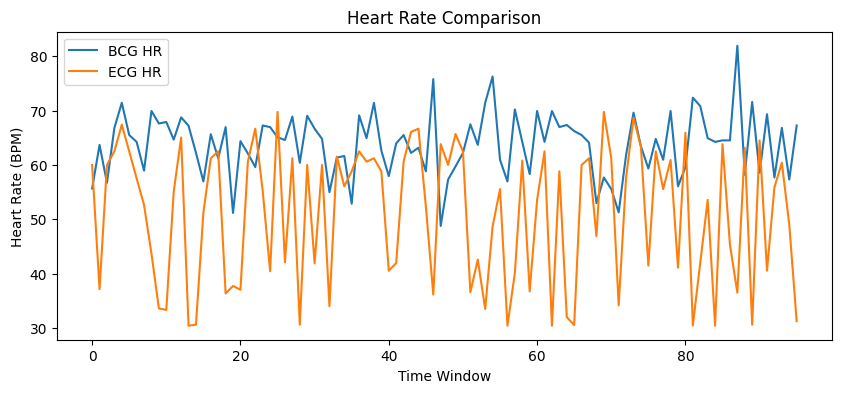


Detecting apnea events...

Apnea Information
start time :  ['07.58.19']  stop time :  ['07.58.19']

Apnea Information
start time :  ['07.58.19', '07.58.19']  stop time :  ['07.58.19', '07.58.19']

Apnea Information
start time :  ['07.58.19', '07.58.19', '07.58.19']  stop time :  ['07.58.19', '07.58.19', '07.58.19']

Apnea Information
start time :  ['07.58.19', '07.58.19', '07.58.19', '07.58.19']  stop time :  ['07.58.19', '07.58.19', '07.58.19', '07.58.19']

Apnea Information
start time :  ['07.58.19', '07.58.19', '07.58.19', '07.58.19', '07.58.19']  stop time :  ['07.58.19', '07.58.19', '07.58.19', '07.58.19', '07.58.19']

Apnea Information
start time :  ['07.58.19', '07.58.19', '07.58.19', '07.58.19', '07.58.19', '07.58.19']  stop time :  ['07.58.19', '07.58.19', '07.58.19', '07.58.19', '07.58.19', '07.58.19']

Apnea Information
start time :  ['07.58.19', '07.58.19', '07.58.19', '07.58.19', '07.58.19', '07.58.19', '07.58.19']  stop time :  ['07.58.19', '07.58.19', '07.58.19', '07.58

In [6]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.signal import butter, filtfilt, resample, savgol_filter
from detect_peaks import detect_peaks
from beat_to_beat import compute_rate

def vitals(t1, t2, win_size, window_limit, sig, time, mpd, plot=0):
    """Calculate vital signs from signal peaks."""
    all_rate = []
    for j in range(0, window_limit):
        sub_signal = sig[t1:t2]
        [rate, indices] = compute_rate(sub_signal, time[t1:t2], mpd)
        all_rate.append(rate)
        t1 = t2
        t2 += win_size
    all_rate = np.vstack(all_rate).flatten()
    return all_rate

def pan_tompkins_detect(ecg_signal, fs):
    """Pan-Tompkins algorithm for QRS detection."""
    # Bandpass filter (5-15 Hz)
    nyq = 0.5 * fs
    low = 5 / nyq
    high = 15 / nyq
    b, a = butter(1, [low, high], btype='band')
    filtered = filtfilt(b, a, ecg_signal)
    
    # Derivative
    derivative = np.gradient(filtered)
    
    # Squaring
    squared = derivative ** 2
    
    # Moving average integration
    window_width = int(0.150 * fs)  # 150 ms window
    integrated = np.convolve(squared, np.ones(window_width)/window_width, mode='same')
    
    # Detect QRS peaks
    peaks = detect_peaks(integrated, 
                        mph=0.5*np.max(integrated), 
                        mpd=int(0.2*fs), 
                        threshold=0, 
                        edge='rising')
    
    return peaks

def main():
    print('\nstart processing ...')

    file = r'C:\Users\omara\OneDrive\Desktop\ECG frm BCG\ECG-from-BCG\sync_data\01\BCG_sync.csv'
    ecg_file = file.replace('BCG_sync.csv', 'RR_sync.csv')

    if file.endswith(".csv"):
        fileName = os.path.join(file)
        if os.stat(fileName).st_size != 0:
            rawData = pd.read_csv(fileName, sep=",", header=None, skiprows=1).values
            utc_time = rawData[:, 1]
            data_stream = rawData[:, 0]
            
            # Convert time to unix
            utc_time = pd.to_datetime(rawData[:, 1], errors='coerce')
            utc_time_numeric = utc_time.astype(np.int64) // 10**6 
            print(f"First timestamp: {utc_time_numeric[0]}")

            # Parameters
            start_point, end_point, window_shift, fs = 0, 500, 500, 140
            window_length = end_point - start_point

            # BCG signal processing
            movement = band_pass_filtering(data_stream, fs, "bcg")
            
            # Respiratory signal processing
            breathing = band_pass_filtering(data_stream, fs, "breath")
            breathing = np.array(breathing, dtype=np.float64)
            breathing = remove_nonLinear_trend(breathing, 3)
            breathing = savgol_filter(breathing, 11, 3)
            
            # Wavelet decomposition
            w = modwt(movement, 'bior3.9', 4)
            dc = modwtmra(w, 'bior3.9')
            wavelet_cycle = dc[4]
            
            # Downsampling to 50Hz
            original_fs = fs
            target_fs = 50
            original_length = len(data_stream)
            target_length = int(original_length * target_fs / original_fs)
            
            downsampled_data_stream = resample(data_stream, target_length)
            downsampled_breathing = resample(breathing, target_length)
            downsampled_wavelet_cycle = resample(wavelet_cycle, target_length)
            
            # Downsample timestamps
            start_time = utc_time_numeric[0]
            end_time = utc_time_numeric[-1]
            downsampled_utc_time_numeric = np.linspace(start_time, end_time, target_length)
            
            print(f'\nDownsampled from {original_fs}Hz to {target_fs}Hz')
            print(f'Original length: {original_length}, New length: {target_length}')
            
            # Update sampling rate
            fs = target_fs
            
            # Vital signs estimation
            t1, t2 = 0, 500
            window_shift = 500
            limit = int(math.floor(len(downsampled_breathing) / window_shift))
            
            # BCG Heart Rate
            print('\nProcessing BCG for Heart Rate...')
            bcg_beats = vitals(t1, t2, 
                              window_shift, 
                              limit, 
                              downsampled_wavelet_cycle, 
                              downsampled_utc_time_numeric, 
                              mpd=int(0.6*fs))
            
            print('\nHeart Rate Information (BCG)')
            print('Minimum pulse :', np.around(np.min(bcg_beats)))
            print('Maximum pulse :', np.around(np.max(bcg_beats)))
            print('Average pulse :', np.around(np.mean(bcg_beats)))
            
            # Respiratory Rate
            print('\nProcessing Respiratory Rate...')
            resp_beats = vitals(t1, t2, 
                               window_shift, 
                               limit, 
                               downsampled_breathing, 
                               downsampled_utc_time_numeric, 
                               mpd=int(0.8*fs))
            
            print('\nRespiratory Rate Information')
            print('Minimum breathing :', np.around(np.min(resp_beats)))
            print('Maximum breathing :', np.around(np.max(resp_beats)))
            print('Average breathing :', np.around(np.mean(resp_beats)))
            
            # ECG Processing if available
            if os.path.exists(ecg_file):
                print('\nECG file found, processing for comparison...')
                try:
                    ecg_df = pd.read_csv(ecg_file, header=None, skiprows=1)
                    ecg_stream = pd.to_numeric(ecg_df[1], errors='coerce').values
                    ecg_stream = pd.Series(ecg_stream).interpolate().values
                    
                    # Downsample ECG
                    downsampled_ecg = resample(ecg_stream, target_length)
                    
                    # ECG Heart Rate
                    ecg_beats = []
                    for i in range(limit):
                        start = i * window_shift
                        end = start + window_length
                        if end > len(downsampled_ecg):
                            break
                        window_ecg = downsampled_ecg[start:end]
                        r_peaks = pan_tompkins_detect(window_ecg, fs=fs)
                        
                        if len(r_peaks) >= 2:
                            rr = np.diff(r_peaks)/fs  # in seconds
                            hr = 60 / np.mean(rr)
                        else:
                            hr = 0
                        ecg_beats.append(hr)
                    
                    # Comparison metrics
                    valid = (np.array(bcg_beats) > 30) & (np.array(ecg_beats) > 30)
                    if np.any(valid):
                        mae = np.mean(np.abs(np.array(bcg_beats)[valid] - np.array(ecg_beats)[valid]))
                        cc = np.corrcoef(np.array(bcg_beats)[valid], np.array(ecg_beats)[valid])[0,1]
                        
                        print(f"\nHR Comparison (BCG vs ECG)")
                        print(f"Mean Absolute Error: {mae:.2f} BPM")
                        print(f"Correlation Coefficient: {cc:.2f}")
                        
                        # Plot comparison
                        plt.figure(figsize=(10,4))
                        plt.plot(np.array(bcg_beats)[valid], label='BCG HR')
                        plt.plot(np.array(ecg_beats)[valid], label='ECG HR')
                        plt.xlabel('Time Window')
                        plt.ylabel('Heart Rate (BPM)')
                        plt.legend()
                        plt.title('Heart Rate Comparison')
                        plt.show()
                    else:
                        print("No valid HR data for comparison")
                except Exception as e:
                    print(f"Error processing ECG file: {str(e)}")
            else:
                print("ECG file not found, skipping comparison")
            
            # Apnea detection
            print('\nDetecting apnea events...')
            events = apnea_events(downsampled_breathing, downsampled_utc_time_numeric, thresh=0.3)
            print(f'Detected {len(events)} apnea events')

if __name__ == "__main__":
    main()